In [ ]:
from google.colab import files
uploaded = files.upload()

Saving LA_Volume_Cleaned.csv to LA_Volume_Cleaned.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("LA_Volume_Cleaned.csv", index_col="Time", parse_dates=True)

In [ ]:
if 'Total_Demand_kWh' not in df.columns:
    df['Total_Demand_kWh'] = df.sum(axis=1)
df = df.select_dtypes(include=[np.number])

target = df[['Total_Demand_kWh']].values

In [ ]:
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)

In [ ]:
def create_sequences(data, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(target_scaled, lookback)

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0411 - val_loss: 0.0060
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 9/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 12/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
MAE: 63.640
RMSE: 119.164
R²: 0.913


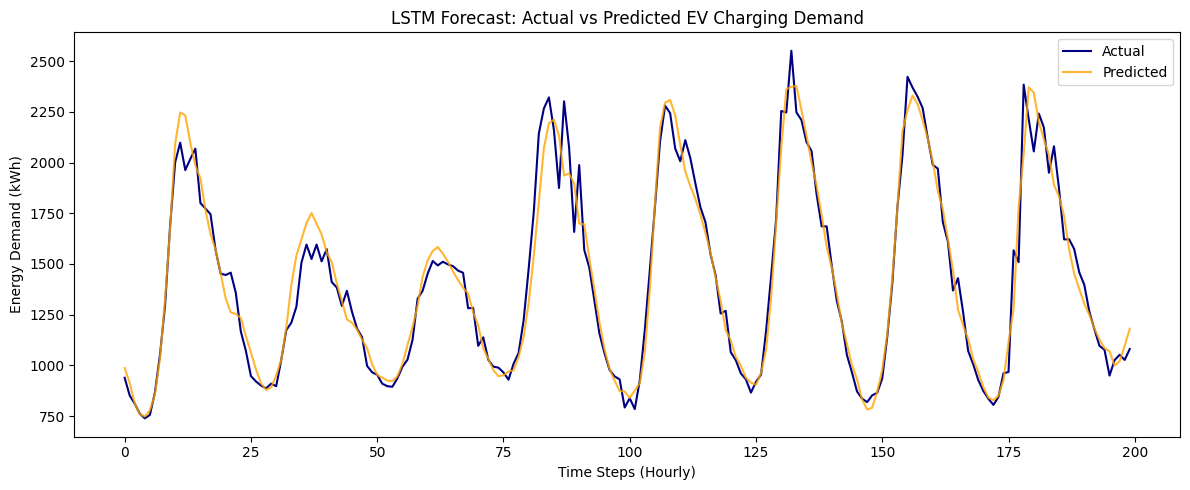

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:200], label='Actual', color='navy')
plt.plot(y_pred_inv[:200], label='Predicted', color='orange', alpha=0.8)
plt.title("LSTM Forecast: Actual vs Predicted EV Charging Demand")
plt.xlabel("Time Steps (Hourly)")
plt.ylabel("Energy Demand (kWh)")
plt.legend()
plt.tight_layout()
plt.show()